# Fetch Data

Fetch data dynamically from an exchange using ccxt

In [ ]:
import ccxt
import pandas as pd
import time

# Fetch OHLCV data and save it to a CSV file
def fetch_and_save_data(symbol, start_date, end_date, timeframe='1h', exchange=ccxt.bybit()):
    start_timestamp = int(pd.Timestamp(start_date).tz_localize('UTC').timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).tz_localize('UTC').timestamp() * 1000)
    ohlcv = []
    while start_timestamp < end_timestamp:
        try:
            data = exchange.fetch_ohlcv(symbol, timeframe, since=start_timestamp, limit=1000)
            if not data: break
            ohlcv.extend(data)
            start_timestamp = data[-1][0] + 1
        except ccxt.NetworkError as e:
            print(f"Network error: {e}. Retrying in 5 seconds...")
            time.sleep(5)
        except ccxt.ExchangeError as e:
            print(f"Exchange error: {e}")
            break
    
    # Create DataFrame and convert to proper datetime format
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    # Save to CSV
    df.to_csv(f'BTC_USDT_1h_22-25.csv')
    print(f"Data saved for period {start_date} to {end_date}")
    

fetch_and_save_data('BTC/USDT', '2022-02-01', '2025-08-16')

Or via fixed CSV file "btc_hourly_ohclv_ta"

In [ ]:
import pandas as pd

# Load the CSV
csv_file = "btc_hourly_ohclv_ta.csv"
df = pd.read_csv(csv_file)

# Select only OHLCV + DATETIME
df = df[['DATETIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']]

# Rename to lowercase
df = df.rename(columns={
    'DATETIME': 'timestamp',
    'OPEN': 'open',
    'HIGH': 'high',
    'LOW': 'low',
    'CLOSE': 'close',
    'VOLUME': 'volume'
})

# Save cleaned version
#df.to_csv("btc_hourly_ohlcv.csv", index=False)

# Back Test Strategy

Get and plot the P&L's of different MACD strategies against a buy-and-hold strategy over a certain timespan.
Variate in length of data, timeframe, fee rate, and combinations for MACD parameters.

Final P&L for combination {'diff': (12, 26, 11), 'signal': (19, 39, 10)}: 6064.888850126078%
Final P&L for combination {'diff': (5, 35, 5), 'signal': (5, 35, 5)}: -24.078605841346008%
Final P&L for combination {'diff': (5, 35, 5), 'signal': (12, 26, 9)}: -42.153813919928524%
Final P&L for combination {'diff': (5, 35, 5), 'signal': (19, 39, 9)}: -45.007435751591316%
Final P&L for combination {'diff': (12, 26, 9), 'signal': (5, 35, 5)}: 2323.7714137653325%
Final P&L for combination {'diff': (12, 26, 9), 'signal': (12, 26, 9)}: 1893.1836772938666%
Final P&L for combination {'diff': (12, 26, 9), 'signal': (19, 39, 9)}: 3126.130320483293%
Final P&L for combination {'diff': (19, 39, 9), 'signal': (5, 35, 5)}: 3472.2167940566287%
Final P&L for combination {'diff': (19, 39, 9), 'signal': (12, 26, 9)}: 1697.993103514006%
Final P&L for combination {'diff': (19, 39, 9), 'signal': (19, 39, 9)}: 2941.0470796395402%


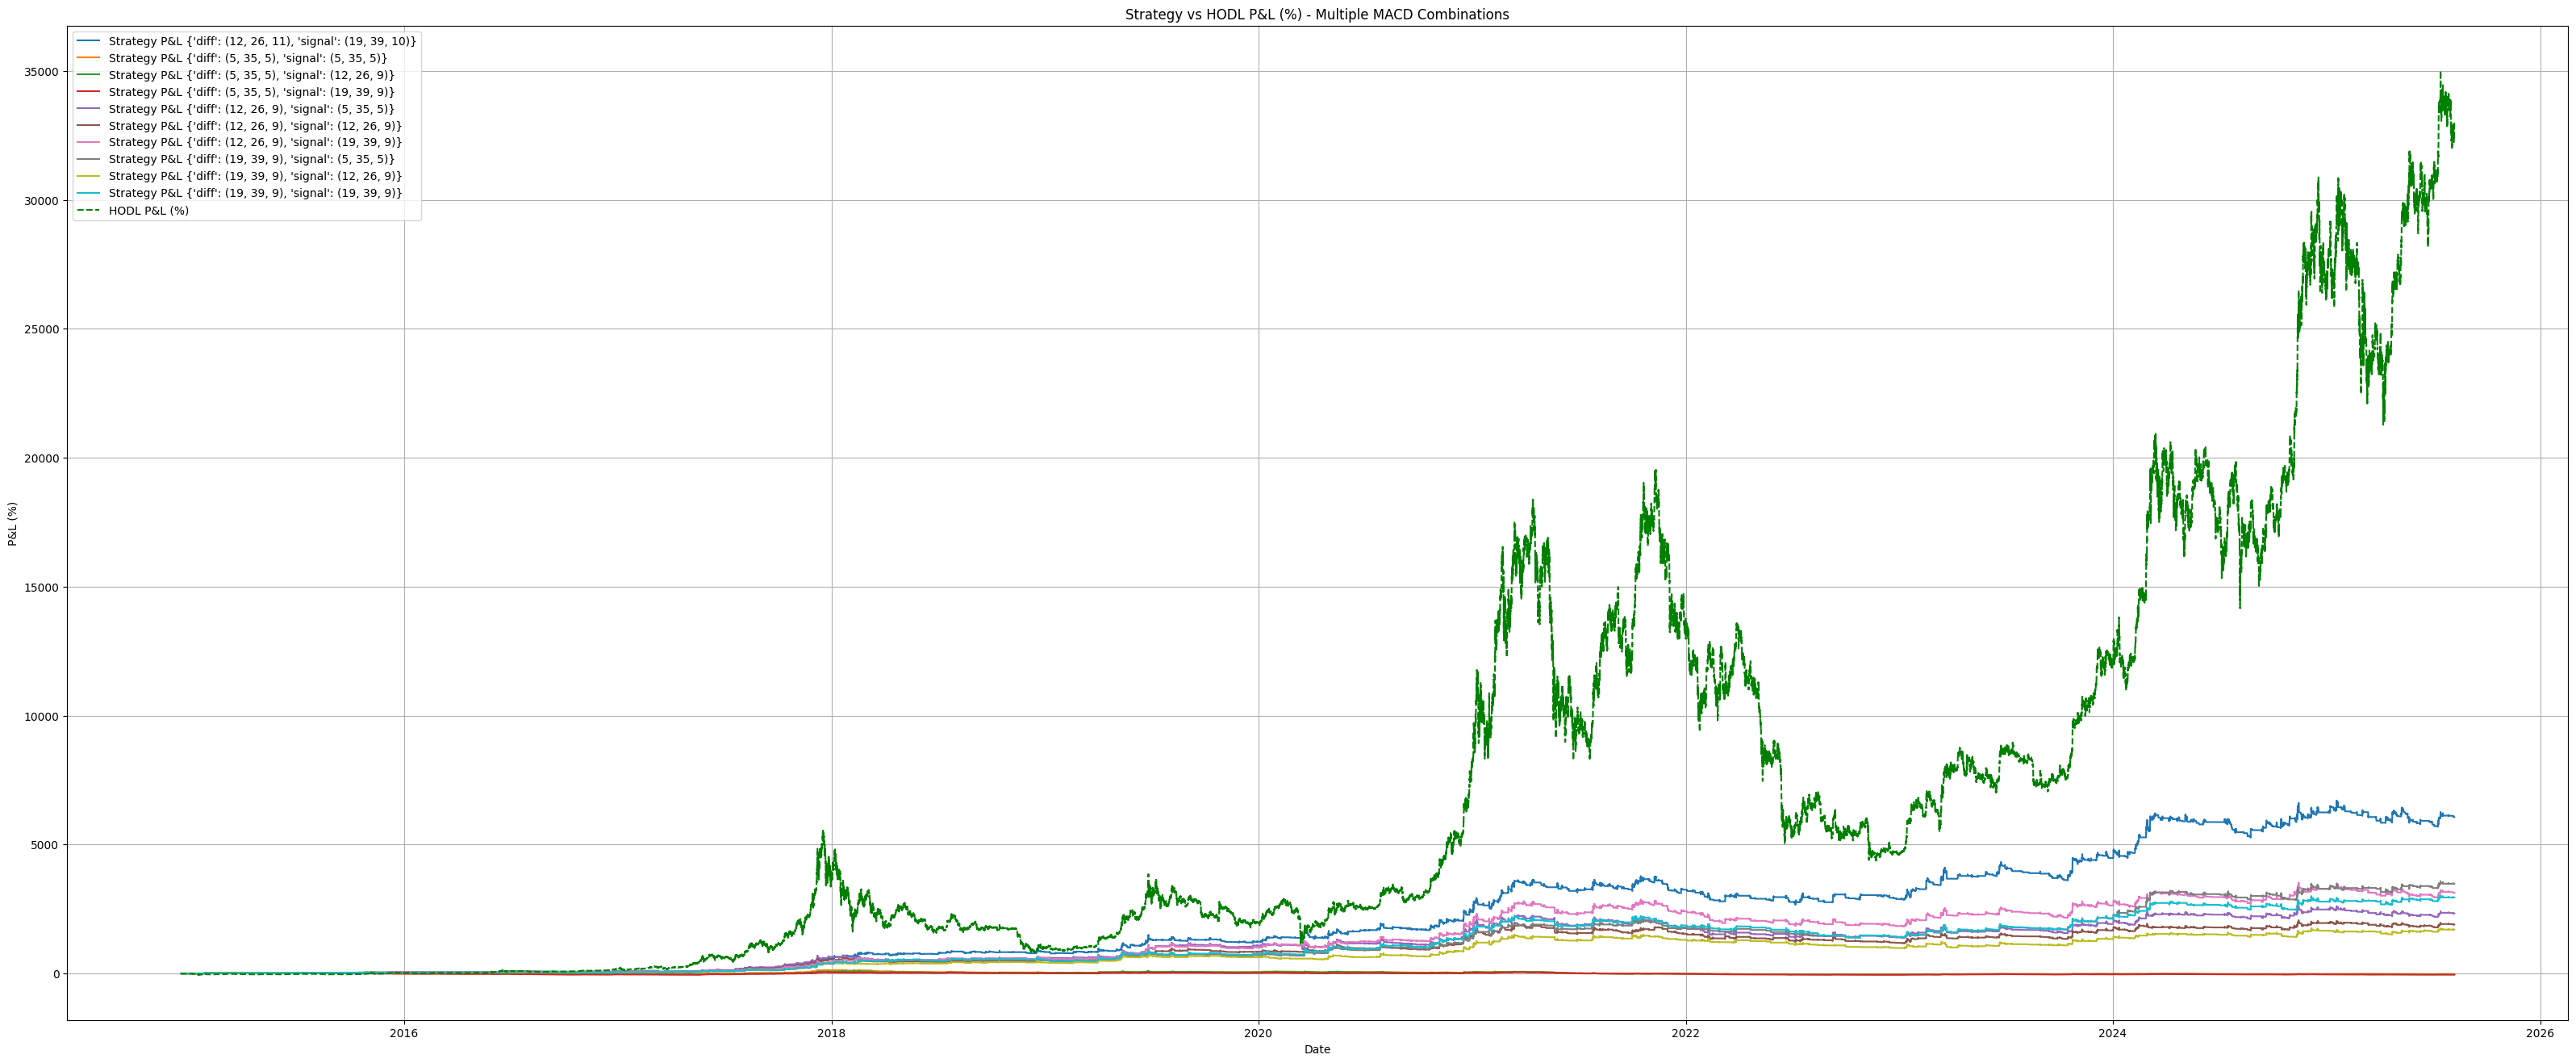

In [ ]:
import pandas as pd
import ta
import matplotlib.pyplot as plt
import numpy as np

# Read in the data and resample based on the given timeframe (e.g., 'T' for minutes, 'H' for hours, 'D' for days)
csv_file = 'btc_hourly_ohlcv.csv'  # Path to your CSV file
timeframe_base = '1h'  # Adjust as needed for your strategy
df = pd.read_csv(csv_file, index_col='timestamp', parse_dates=True)
df = df.resample(timeframe_base).agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}).dropna()

# Function to apply MACD with different labels for different conditions
def apply_macd(df, fast, slow, signal, label):
    macd = ta.trend.MACD(df['close'], window_slow=slow, window_fast=fast, window_sign=signal)
    df[f'macd_{label}'] = macd.macd()
    df[f'macd_signal_{label}'] = macd.macd_signal()
    df[f'macd_diff_{label}'] = macd.macd_diff()
    return df

# Initialize variables for tracking strategy performance
initial_balance = 10000  # Starting balance in USDC (just for reference)
fee_rate = 0.0005  # 0.05% (0.0005) trading fee
hold_balance = initial_balance / df.iloc[0]['close']  # Simulate buy and hold from the start

combinations = [
    # Special best-performer (naive deduction)
    {'diff': (12, 26, 11), 'signal': (19, 39, 10)},

    # Cartesian product of (5,35,5), (12,26,9), (19,39,9)
    {'diff': (5, 35, 5), 'signal': (5, 35, 5)},
    {'diff': (5, 35, 5), 'signal': (12, 26, 9)},
    {'diff': (5, 35, 5), 'signal': (19, 39, 9)},

    {'diff': (12, 26, 9), 'signal': (5, 35, 5)},
    {'diff': (12, 26, 9), 'signal': (12, 26, 9)},
    {'diff': (12, 26, 9), 'signal': (19, 39, 9)},

    {'diff': (19, 39, 9), 'signal': (5, 35, 5)},
    {'diff': (19, 39, 9), 'signal': (12, 26, 9)},
    {'diff': (19, 39, 9), 'signal': (19, 39, 9)},
]

pnl_results = []
hold_pnl = []

# Loop over the different MACD combinations
for combo in combinations:
    df = apply_macd(df, *combo['diff'], label='diff')
    df = apply_macd(df, *combo['signal'], label='signal')

    # Initialize balance and position variables for each run
    balance = initial_balance
    btc_balance = 0
    in_position = False
    pnl = []

    # Simulate the buy/sell strategy
    for i in range(1, len(df) - 1):  # leave room for i+1
        prev_macd_diff = df['macd_diff_diff'].iloc[i-1]
        curr_macd_diff = df['macd_diff_diff'].iloc[i]
        macd_signal = df['macd_signal_signal'].iloc[i]

        if not in_position:
            # Buy condition: MACD diff turns positive from negative and MACD signal is positive
            if prev_macd_diff < 0 and curr_macd_diff > 0 and macd_signal > 0:
                btc_balance = (balance * (1 - fee_rate)) / df['open'].iloc[i+1]  # Buy at the next open price
                balance = 0
                in_position = True
        else:
            # Sell condition: MACD diff turns negative 
            if curr_macd_diff < 0:
                balance = (btc_balance * df['open'].iloc[i+1]) * (1 - fee_rate) # Sell at the next open price
                btc_balance = 0
                in_position = False

        # Track P&L for the current combination
        total_value = balance if balance > 0 else btc_balance * df['open'].iloc[i+1]
        pnl.append((total_value - initial_balance) / initial_balance * 100)

    # Append final P&L to results
    if in_position:
        balance = btc_balance * df['close'].iloc[-1] * (1 - fee_rate)
    final_pnl = (balance - initial_balance) / initial_balance * 100
    pnl_results.append({
        'combination': combo,
        'pnl': pnl,
        'final_pnl': final_pnl
    })
    print(f"Final P&L for combination {combo}: {final_pnl}%")

    # HODL P&L - same for all runs, so calculate once
    if not hold_pnl:
        for i in range(1, len(df)):
            hold_pnl.append((hold_balance * df['close'].iloc[i] - initial_balance) / initial_balance * 100)

# Plotting the strategy P&L for each combination and the HODL line
plt.figure(figsize=(40, 16))
for result in pnl_results:
    plt.plot(df.index[:len(result['pnl'])], result['pnl'], label=f"Strategy P&L {result['combination']}", linestyle="-")
plt.plot(df.index[:len(hold_pnl)], hold_pnl, label="HODL P&L (%)", color="green", linestyle="--")
plt.title("Strategy vs HODL P&L (%) - Multiple MACD Combinations")
plt.xlabel("Date")
plt.ylabel("P&L (%)")
plt.legend()
plt.grid(True)
plt.show()



Using a log scale on the plot shows relative growth

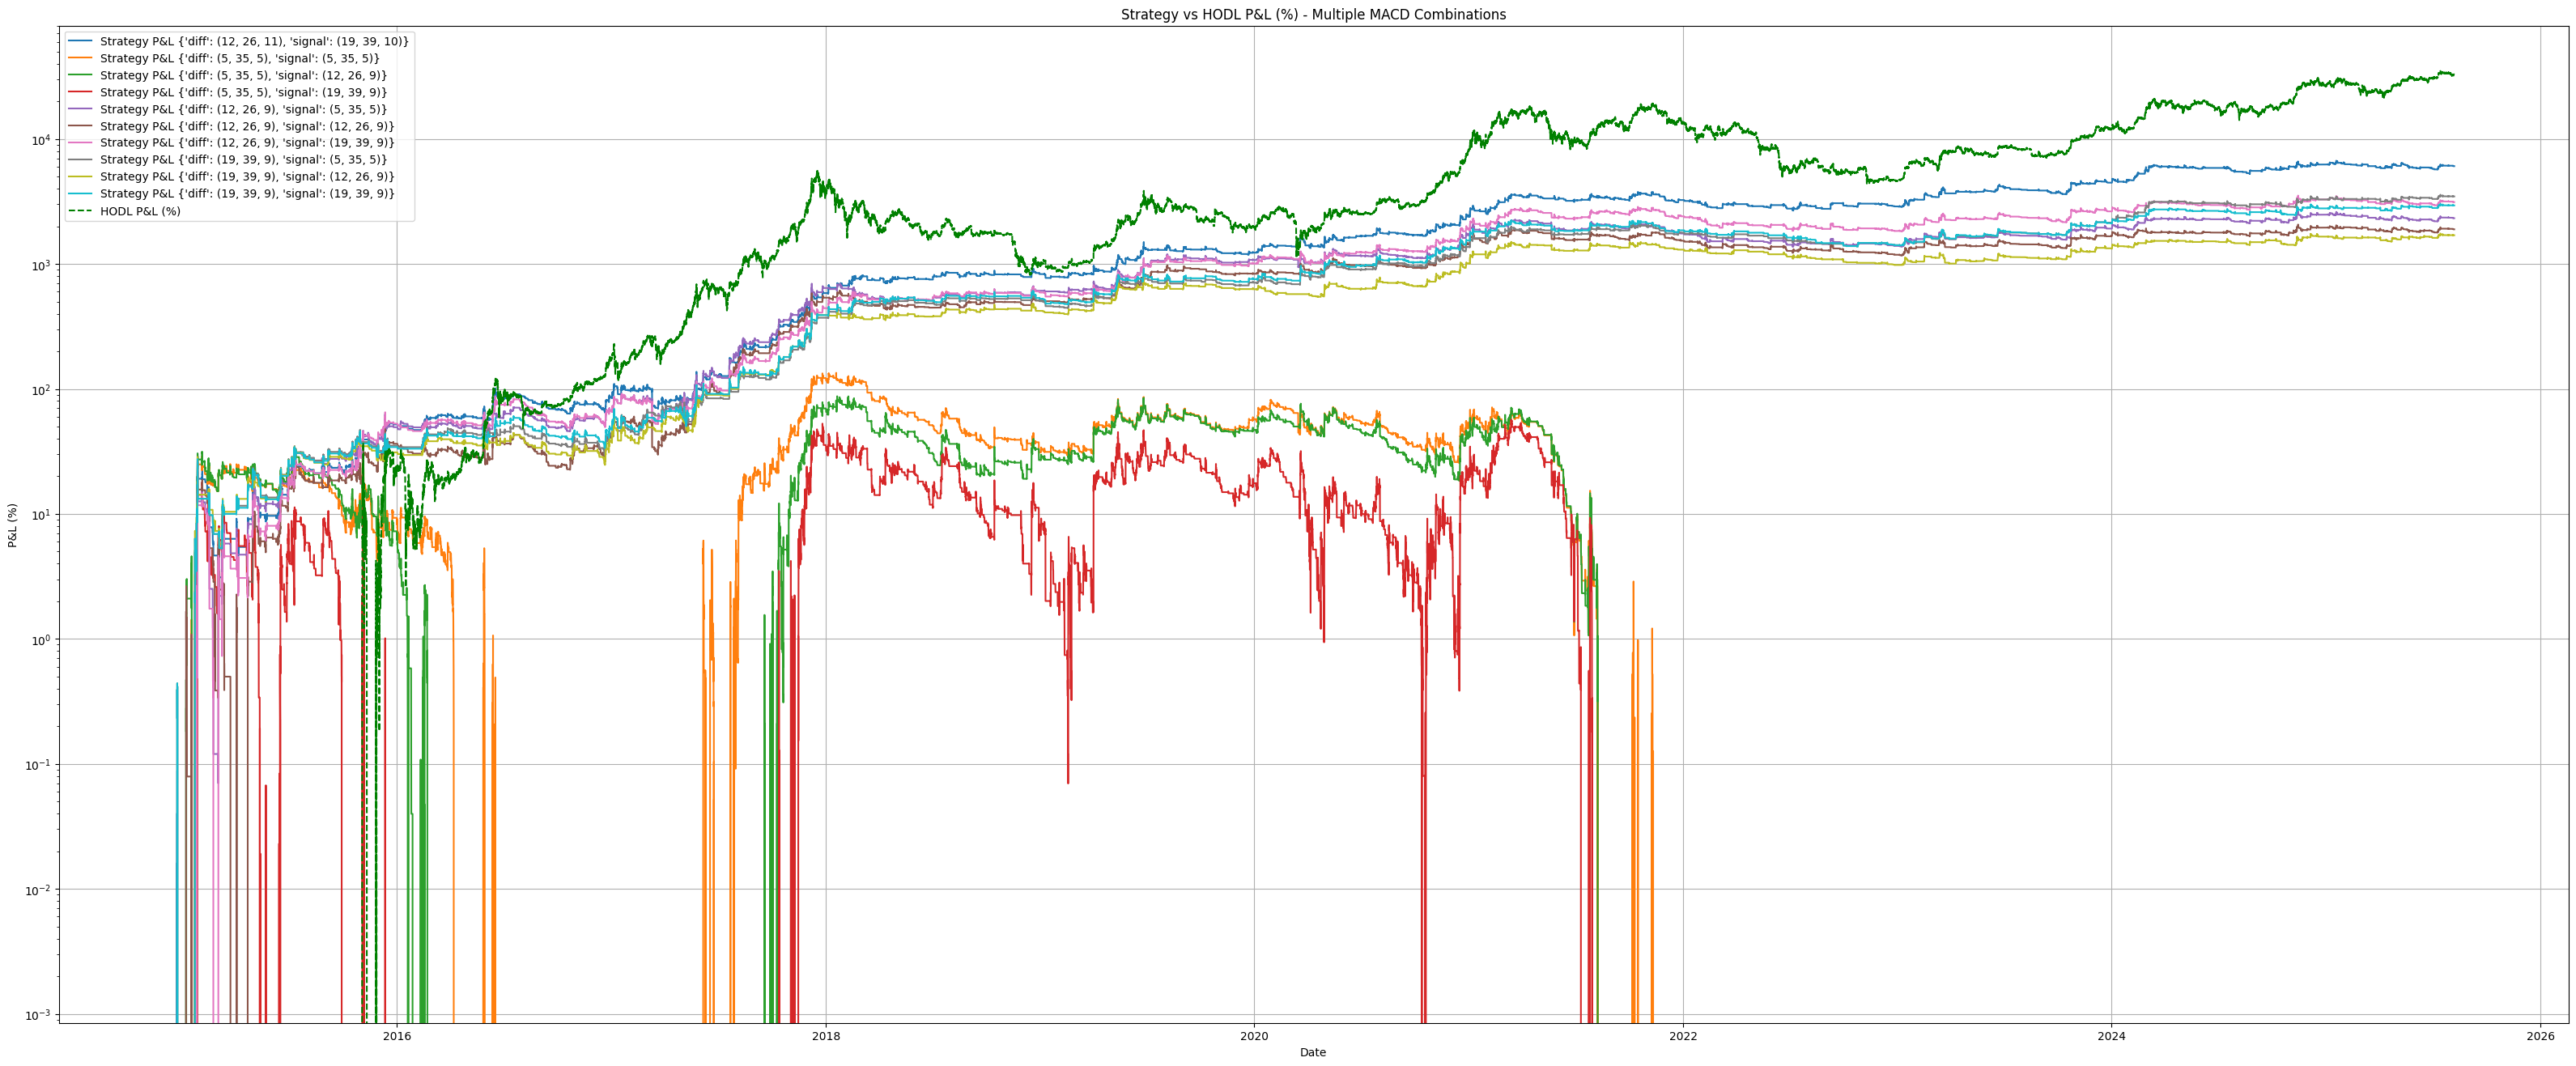

In [ ]:
# Plotting the strategy P&L for each combination and the HODL line in log scale
plt.figure(figsize=(40, 16))
for result in pnl_results:
    plt.plot(df.index[:len(result['pnl'])], result['pnl'], label=f"Strategy P&L {result['combination']}", linestyle="-")
plt.plot(df.index[:len(hold_pnl)], hold_pnl, label="HODL P&L (%)", color="green", linestyle="--")
plt.title("Strategy vs HODL P&L (%) - Multiple MACD Combinations")
plt.xlabel("Date")
plt.ylabel("P&L (%)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()